# Analysis of New York City High School Data

### 1. Intoroduction 
In this project we will be analyzing factors that contribute to SAT (Scholastic Aptitude Test) scores. Each year in the U.S, seniors in high school take the SAT's. The exam has a maximum score of 1600, and universities use their scores to detemine what students to admit.

In the U.S, standardized testing eficacy is a controvercial topic. The goal of this project is to detemine whether certain demographics factors such as race, income and gender contribute to the SAT scores. And guide to advice on the authecity of these tests. 

For example, if certain racial groups do better on the tests we can conclude that it is unfair. 

[New Yourk City Data on High School SAT Scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4)

[Denograohics for each high school](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2)

We will be combiing 7 datasets into 1 for our analysis:
 - `AP test results`: Advanced Placement (AP) exam results for each high school. 
 
 
 - `Class size`: Class size data for each school. 
 
 
 - `Demographics`: Demographics information for each school.
 
 
 - `Graduation outcomes`: Percentage of students who graduated and other outcome information.
 
 
 - `SAT Scores by school`: SAT scores for each high school in New York City.
 
 
 - `School attendance`: Attendance informaiton for each school in New Yourk City.
 
 
 - `School survey`: Surveys of parents, teachers and students at each school 
 
 
### 2.1 Reading in the Datasets

In [1]:
import pandas as pd
import numpy as np 


data_files =  [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    open_f = pd.read_csv("datasets/{0}".format(f))
    data[f.replace(".csv", "")] = open_f


### 2.2 Reading in Survey Data

We read the survey data separately because they are in txt format. We will combine both the survey_all and survey_d75 into a single dataset using the pd.concat() method. We will then add this dataset to the data dictionary. 

In [2]:
all_survey = pd.read_csv('datasets/survey_all.txt', delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("datasets/survey_d75.txt", delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0)

# Chaingind dbn to Uppercase 
survey["DBN"] = survey["dbn"]

survey_fields = ["DBN", "rr_s", "rr_t", 
                    "rr_p", "N_s", "N_t", 
                    "N_p", "saf_p_11",
                    "com_p_11", "eng_p_11",
                    "aca_p_11", "saf_t_11",
                    "com_t_11", "eng_t_11",
                    "aca_t_11", "saf_s_11", 
                    "com_s_11", "eng_s_11", 
                    "aca_s_11", "saf_tot_11",
                    "com_tot_11", 
                    "eng_tot_11", 
                    "aca_tot_11"]

survey = survey.loc[:, survey_fields]
data["survey"] = survey


/var/folders/5h/p59z3njd3x5b0ts12p6_6v3w0000gn/T/ipykernel_42369/1875142191.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  survey["DBN"] = survey["dbn"]


### 2.3 Adding DBN Columns

The DBN represents the School Indentification Code (District Borough Number). Studying the datasets revels that the `class_size` dataset does not have a DBN column, and the `hs_directory` dataset DBN column name is written in lower-case. 
- We will add a DBN column to the `class_size` dataset by combining the CDS and SCHOOL CODE columns. THE DBN is just a combination of these two. 


In [3]:
# Converting dbn column to uppercase.
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"] 


# define a function pas_csd()
def pad_csd(num):
    return str(num).zfill(2)

#impliment the above function using Series.apply() method on CSD column
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

#create the new DBN column adding padded_csd and SCHOOL CODE columns
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
        

### 2.4 Combining the SAT Scores 

In the sat_result dataset, the three columns SAT Math Avg. Score, SAT Critical Reading Avg. Score & SAT Writing Avg. Score add up to the total SAT score for all sections of the exam. 

Working on a single number rather than 3 make it easier to correlate scores with demograohic factors. These columns are all in string format and need to be comverted to numeric type before adding them up. 

In [4]:
#convert the following three column into numeric type using pd.to_numeric() method & add them up
cols = ['SAT Math Avg. Score', 
        'SAT Critical Reading Avg. Score', 
        'SAT Writing Avg. Score']

for c in cols: 
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
display(data["sat_results"]["sat_score"].head(3))

0    1122.0
1    1172.0
2    1149.0
Name: sat_score, dtype: float64

### 2.5 Parsing Geographic

Next, we will be parsing the latitude and logitude coordinates for each school. This will allow us to map the schools and undercover any geographical patterns in the data. 
The coordinates for each school can be found at the end of each `Location 1` column entry in the `hs_directory`.

#### Extracting the Longitude & Latitude


In [5]:
import re 

#create find_lat() & find_lon() functions to extract latitude & longitude seperately
def find_latitude(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat
    
def find_longitude(loc):
    coords = re.findall("\(.+\)", loc)
    lat = coords[0].split(",")[1].replace(")", "")
    return lat

#using Series.apply() method impliment the above functions & extract the latitudes and longitudes
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_latitude)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_longitude)

#convert the lat & lon columns into numeric type using pd.to_numeric() method
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")
display(data["hs_directory"].head(3))


,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA,DBN,lat,lon
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,27Q260,40.601989,-73.762834
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,NaN,NaN,...,"2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...",13.0,47.0,306.0,3186454.0,3.068830e+09,Gravesend ...,21K559,40.593594,-73.984729
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,NaN,NaN,...,"1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...",3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...,16K393,40.692134,-73.931503


### 2.5 Condensing the Datasets
 
**Condensing Class Size**

The `sat_results` dataset contains multiple entries under the same `DBM` number. We will be condensing the dataset to make combining datasets easier. 
We will separate the class_size dataset from the data dictionary for further analysis. We are only interested in high school, we need to filter the GRADE column by selecting only `09-12` grades and the PROGRAM TYPE column by selecting only `GEN ED`.

**Computing Avergae Class Size**

The `DBN` still isn't unique in the `class_size` dataframe and this is due to the `CORE COURSE (MS CORE and 9-12 ONLY)` & `CORE SUBJECT (MS CORE and 9-12 ONLY)` columns. These seem to be special kind of classes. 
We want our `class_size` to include all the classes in each school, not just a subset of them. We will take the average across all the classes. 

**Condensing the Demographics Dataset**

In the demographics dataset, we are only interested in the most recent school year (`20112012`). We will filter this uear from the schoolyear column. 

**Condensing the Graduation Dataset**
The Demographic and Cohort columns prevent DBN from being unique in the graduation dataset. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.


In [6]:
#from the class_size select grades '09-12' & program type 'GEN ED'
class_size = data["class_size"][(data["class_size"]["GRADE "] == "09-12") & (data["class_size"]["PROGRAM TYPE"] =="GEN ED")]


#calculate the average class size value for each school using Series.groupby().agg() method
# Aggregate according DBN numbers & find mean of group 
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size 

#select 20112012 schoolyear from the demographics dataset
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

#filter year 2006 from Cohort column & total Cohort from the Demographics column in graduation dataset
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == '2006']
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]
                     


### 2.6 Converting AP Test Scores to Numerical Values. 

*Advanced Placement* (AP) test is an exam students take before applicing to university. There are different AP exams for different subjects. Earning a score above 3 (AP exams have 1 to 5 scale) may recieve college credit. It eill be interesting to explore wether AP exam scores corrolate with SAT scores across high schools. 
- Firstly we need to convert AP exam scores in the *ap_2019* data set to numeric values. 

In [7]:
#convert the columns related to AP exams in ap_2010 dataset to numeric value
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for c in cols:
    data["ap_2010"][c] = pd.to_numeric(data["ap_2010"][c], errors="coerce")


### 2.7 Combining the Datasets

Since we want our final datframe to have the same *DBN* values as the original sat_esults dataframe, we will use *pandas.dataframe.merge()* method with a keyword argumne t *how='left'* and *on='DBN'*. 
- First we will assign sat_results to the variable *combined*, then we will merge the other dataframes with combined. 
- Next we will do an inner join to merge `combined` and the remaiing datasets. 

In [8]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")
    
# fill the null values with mean value using df,fillna() method & 
# any remaining null value with 0 value. 
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)


/var/folders/5h/p59z3njd3x5b0ts12p6_6v3w0000gn/T/ipykernel_42369/1990577989.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined = combined.fillna(combined.mean())


### 2.8 Adding a School District Column for Mapping

Finally, we are done with cleaning and combining the data. An interesting way of analyzing it is to map the statistics out on a school district level. Adding a column to the data which specifies the school district will help us achieve this. School district is just the first two characters of the DBN. We will write a function get_first_two_chars() inorder to accomplish this.


In [9]:
#define a function to extract first two characters of DBN 
def extract_district(dbn):
    return dbn[0:2]

#Apply the above function on DBN columnm & store it in a new column called school_dist
combined["school_dist"] = combined["DBN"].apply(extract_district)


## 3. Finding Correlations

Correlations show how closely any two columns are related. We will use pd.df.corr() method to find the correlation between different columns in our dataset. The method returns a new dataframe where the index for each column and row is the name of a column in the original dataset.


#### Finding Correlations With the  rValue


In [29]:
#create a new dataset correlations with correlation values between the columns
correlations = combined.corr()

#filter just the sat_score in the correlation dataset & print the values
correlations = correlations["sat_score"]
display(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
ap_per                             0.057171
Name: sat_score, Length: 86, dtype: float64

From the above data we can make the following observations: 
- The *SAT Critical Reading Avg. Score, SAT Math Avg. Score, SAT Writing Avg. Score, and sat_score strongly* correlate with sat_score.
- The `total_enrollment` column has a strong positive correlation with sat_score. This is suprising because we would expect smaller schols where students recieve more attention to have higher scores. Other similar columns total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS correlate similarly. 
- Both the percentage of females female_per and number of females female_num at a school correlate positively with SAT score, whereas the percentage of males male_per and the number of males male_num correlate negatively. This indicates that girls do better in SAT than boys.
- Teacher and student ratings of school safety saf_t_11, and saf_s_11 correlate with sat_score.
- Student ratings of school academic standards aca_s_11 correlate positively with sat_score, but this does not apply to the ratings from teachers and parents aca_p_11 and aca_t_11.
- There is significant racial inequality in SAT scores, i.e. correlation is highest for white_per and then for asian_per, both being positive. But black_per, hispanic_per correlates negatively with the latter being lowest.
- The percentage of English language learners at the school ell_percent, frl_percent has a strong negative correlation with SAT score.



## 4. Plotting Total Enrollement Correlations 

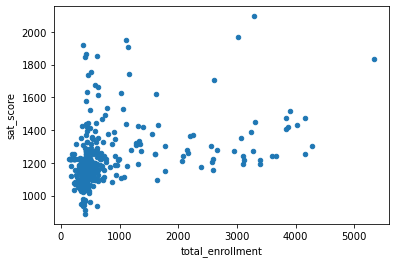

In [12]:
import matplotlib.pyplot as plt 

combined = combined.dropna(subset=['sat_score'])
combined.plot.scatter(x="total_enrollment", y="sat_score")
plt.show()

From the plot above, there doesn't seem to be a strong corrolatino between sat_score and total enrollemnt. If there was a strong corrolation, we would expect the points to line up. 

However, there is an interesting cluster of schools in the bottom left of the plot. This might be whats making the r value so high. It is worth extracting the names of the schools in this closter so we can reaserch them further.  

In [13]:
low_enrollment = combined[combined["total_enrollment"] < 1000]
low_enrollment = low_enrollment[low_enrollment["sat_score"] < 1000]
print(low_enrollment["SCHOOL NAME"])


91                  INTERNATIONAL COMMUNITY HIGH SCHOOL
125                 ACADEMY FOR LANGUAGE AND TECHNOLOGY
126                     BRONX INTERNATIONAL HIGH SCHOOL
139               KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141               INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176    PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
179                       HIGH SCHOOL OF WORLD CULTURES
188                  BROOKLYN INTERNATIONAL HIGH SCHOOL
225       INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS
237                          IT TAKES A VILLAGE ACADEMY
253                           MULTICULTURAL HIGH SCHOOL
286              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools are have a low percentage of enlish speaking learners. This indicates that it is actually `ell_percent` that corrolates strongly with `sat_Score`, rather than `total_enrollment`.

### Relationship between `ell_percent` vs `sat_score`.

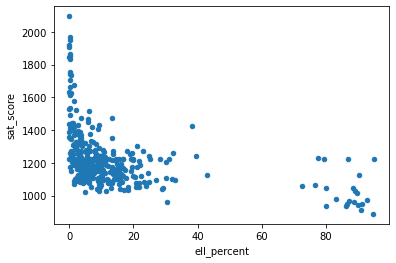

In [14]:
combined.plot.scatter(x='ell_percent', y='sat_score')
plt.show()

 The `ell_percent` has a strong negative correlation with `sat_score

In [15]:
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)


## 5. Plotting Survey Correlations

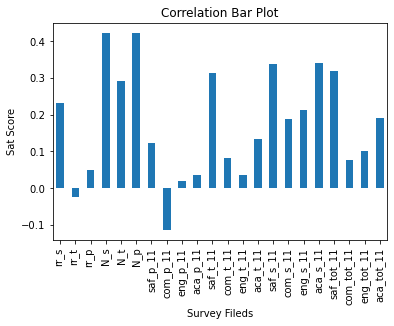

In [35]:
#make a bar plot of correlations between these relevant fields & sat_score
correlations.loc["rr_s" : "aca_tot_11"].plot.bar()
plt.xlabel('Survey Fileds')
plt.ylabel('Sat Score')
plt.title('Correlation Bar Plot')
plt.show()


The graph above depicts the correlation between `sat_Score` and `survey_fields`. We can make the following observaitnof from the graph:
- `rr_t`(teacher response rate) and `com_p_11` (communication score based on parent responses) are the only ones with a negative correlation.
- Highest correlations are `N_s` and `N_p` (number of students and parents that respond to the survey) ~ 0.42. 
- The next highest correlations are `saf_s_11` (safety and respect score based on student responses) and `aca_s_11` (academic expectations score based on student responses) at ~0.34.
- The third highest correlations are `saf_t_11` (safety and respect score based on teacher responses) and `saf_tot_11` (safety and respect total score) at ~0.31.



### 5.1 Exploring Safety and SAT Scores

The above analysis indicated that how students, parents and teachers percieve safety all correlate with SAT scored positively. We will dig deeper into the relationship to figure out which schools have low safetry scores. 

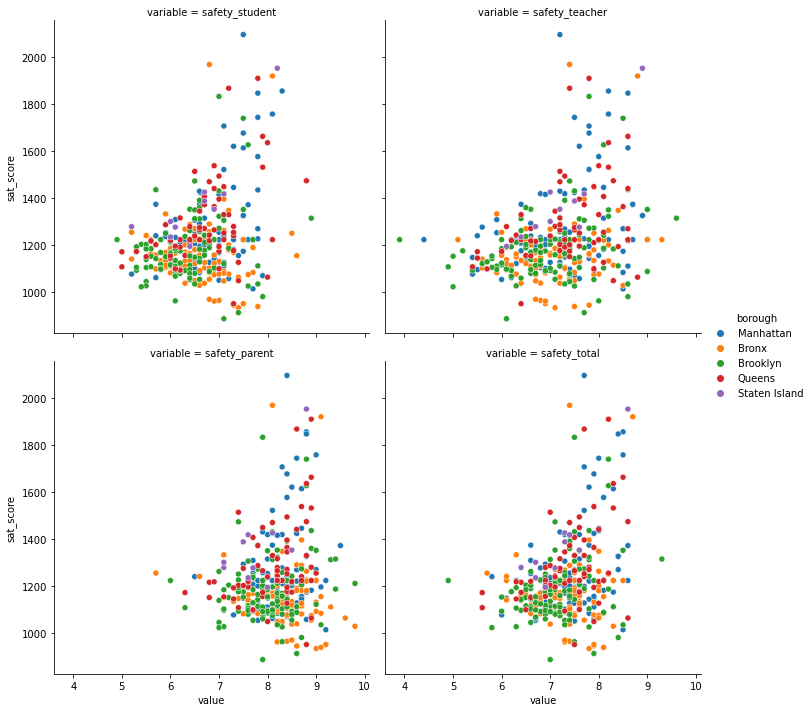

In [17]:
boroughs = combined[["borough", "DBN", "sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
boroughs_columns = ["borough", "DBN", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
boroughs.columns = boroughs_columns
boroughs = boroughs.melt(id_vars=["borough", "DBN", "sat_score"])


import seaborn as sns 
sns.relplot(data=boroughs, x="value", y="sat_score", hue="borough", col="variable", col_wrap=2)
plt.show()

The safety score has a positive corrolation with SAT csores.

In [18]:
borough_means = combined[["borough",  "sat_score", "saf_s_11", "saf_t_11", "saf_p_11", "saf_tot_11"]]
borough_columns = ["borough", "sat_score", "safety_student", "safety_teacher", "safety_parent", "safety_total"]
borough_means.columns = borough_columns
borough_means = borough_means.groupby("borough").agg(np.mean)
borough_means.reset_index(inplace=True)
display(borough_means)

,borough,sat_score,safety_student,safety_teacher,safety_parent,safety_total
0,Bronx,1157.598203,6.606577,7.026882,8.346237,7.322581
1,Brooklyn,1181.364461,6.370755,6.985849,8.036792,7.129245
2,Manhattan,1278.331410,6.831370,7.287778,8.288889,7.473333
3,Queens,1286.753032,6.721875,7.365625,8.098437,7.387500
4,Staten Island,1382.500000,6.530000,7.210000,7.800000,7.200000


#### Observations

The scatter plots show two areas influencing the correlation between SAT scores and perceptions of safety and respect. First, the highest SAT scores come from schools with above average perceptions of safety and respect. Second, it looks like most schools have both SAT and safety and respect scores below the median values. It is also interesting that parents have a noticeably higher perception of safety and respect than either teachers or students.

Grouping schools by borough and averaging scores paints a different picture. This seems to indicate that SAT scores and perception of safety do not have a strong positive correlation at all. For instance, Staten Island has the highest average SAT scores and Bronx the lowest. However, the student and parent perception of safety and respect scores are higher in the Bronx than in Staten Island. And while Manhattan has the highest total safety and respect scores, it ranks in the middle for SAT scores. So while using mean for comparison is a start, the scatter plot charts show a much more granular view that is closer to reality.


## 6. Exploring Race & SAT Scores

Next we will be looking at the relationship between race & ethnicity and SAT scores in NYC schools. There are four races listed in the data. These are Whites, Asians, Blacks and Hispanics.

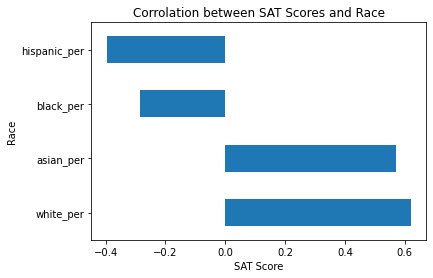

In [37]:
races = correlations[[ "white_per", "asian_per", "black_per", "hispanic_per"]]
races.plot(kind='barh', title='Corrolation between SAT Scores and Race')
plt.xlabel('SAT Score')
plt.ylabel('Race')
plt.show()


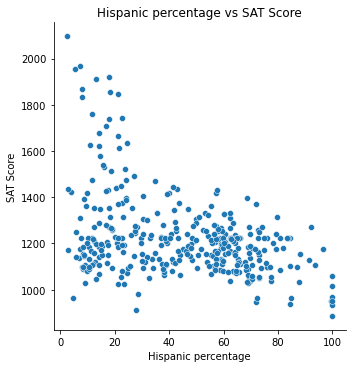

In [39]:
# scatter plot for sat_scores and percent Hispanic
sns.relplot(data=combined, x="hispanic_per", y="sat_score")
plt.xlabel('Hispanic percentage')
plt.ylabel('SAT Score')
plt.title('Hispanic percentage vs SAT Score')
plt.show()

#### Observations 

From the bar chart above, it is very clear there is a differnce in correlation values for different races and sat_score. First highest is for whites at ~ 62% and second highsest is for Asians, slightly lower at ~ 57%. But for blacks and hispanics, it is negative at ~ -28% and ~ -40% respectively.
It does not does not paint a clear picture though, it shows a moderately strong corrolation between SAT scores and percentage of hispanic students in the school. 

That being said, the scatter plot suggests something a little more nuanced. There is a negative trend between SAT Score and Hispanic percentage.At schools with low percentage of hispanics the SAT Score is considerably higher. With increase in the percentage of hispanics, SAT Score decreases exponentially. Higher the percentage of hispanics lower the SAT Score. 

**Below we will explore the schools with higher hispanics percentage, i.e. above 95%.**



In [40]:
hispanic_95 = combined[combined['hispanic_per']> 95.0]
hispanic_95[['SCHOOL NAME', 'hispanic_per']] 

,SCHOOL NAME,hispanic_per
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8
253,MULTICULTURAL HIGH SCHOOL,99.8
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0


These 8 schools have above 95% of hispanics enrolled. In these schools atleast 80% of students are economically disadvantaged, in some schools 100% students are economically disadvantaged. 
These schools have very low national rankings ranging from above 1000 and in some cases even closer to 10000. New York High Schools rankings is also lower for these schools, in some cases above 100 and in others closer to 800. The minority enrolment in these schools are almost 100%.

**Below we will explore the schools with percentage of hispanics less than 10% and average SAT Score greater than 1800.**



In [41]:
hisp_10 =  combined[(combined['hispanic_per']<10.0) & (combined['sat_score']>1800)]
hisp_10[['SCHOOL NAME', 'sat_score', 'hispanic_per']]

,SCHOOL NAME,sat_score,hispanic_per
37,STUYVESANT HIGH SCHOOL,2096.0,2.4
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,7.2
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,7.9
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,7.9
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,5.3


There are only 5 schools in the list which have less than 10% of hispanics and more than 1800 SAT Scores. Among these schools therei s a lower percentage of economically disadvantaged students, highest being ~ 60%. 

The national rankings of these schools are very good as well,  highest being 22 and lowest being 44. There are also all amongst the top 10 High Schools in  New York. 


## 7. Exploring Gender & SAT Scores

There are two columns in the dataframe which indicate the percentage of gender.
- male_per (male percentage)
- female_per (female percentage)


In here we will investigate the correlation between these two columns and the SAT score. First we will plot the correlation and study the graph.

**Bar Plot**

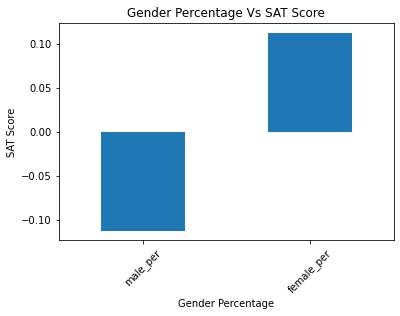

In [44]:
gender = correlations[["male_per", "female_per"]]
gender.plot(kind='bar')
plt.xlabel('Gender Percentage')
plt.ylabel('SAT Score')
plt.title('Gender Percentage Vs SAT Score')
plt.xticks(rotation=45)
plt.show()

**Scatter Plot**

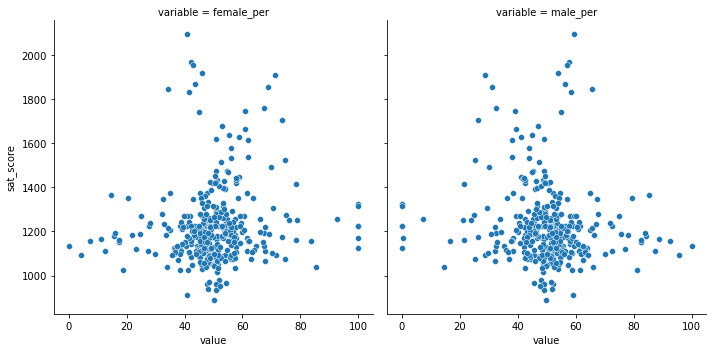

In [49]:
genders = combined[["borough", "DBN","SCHOOL NAME", "sat_score", "female_per", "male_per"]]

genders_melt = genders.melt(id_vars=["borough", "DBN", "sat_score", "SCHOOL NAME"])

sns.relplot(data=genders_melt, x="value", y="sat_score", col="variable")
plt.show()


In [23]:
# caluculate percentage female to male
all_the_kids = combined["NUMBER OF STUDENTS / SEATS FILLED"]
per_female = combined["female_per"].mean()
per_male = combined["male_per"].mean()
print("Total students =", all_the_kids.sum())
print("Percent female =", per_female)
print("Percent male =", per_male)


Total students = 62349.76177031602
Percent female = 50.62066115702485
Percent male = 49.37851239669419


In [24]:
# create sat_score over 1700 data set with female and male percentages
smart_kids = genders.iloc[:,2:6][genders["sat_score"] > 1700]
display(smart_kids)


,SCHOOL NAME,sat_score,female_per,male_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7,31.3
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5,32.5
37,STUYVESANT HIGH SCHOOL,2096.0,40.7,59.3
60,BEACON HIGH SCHOOL,1744.0,61.0,39.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6,26.4
79,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",1847.0,34.2,65.8
151,BRONX HIGH SCHOOL OF SCIENCE,1969.0,42.2,57.8
155,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,1920.0,46.2,53.8
187,BROOKLYN TECHNICAL HIGH SCHOOL,1833.0,41.7,58.3
198,"BROOKLYN LATIN SCHOOL, THE",1740.0,45.1,54.9


Three things from the results that stand out:
- First, the ratio of male to female students seems to have little to no effect on SAT scores.
- Second, among the schools with SAT scores over 1700, there are five with over 60% female students and two with over 70%. There is only one with over 60% male students and none with over 70%. The two schools with the highest number of females are Townsend Harris High School (consistently ranked among the 100 best high schools in America) and LaGuardia High School. Both are magnet schools. The two schools with the highest average SAT scores are Stuyvesant High School (59% male) and Bronx High School of Science (58% male). Both of these are also magnet schools.
- Third, particularly interesting from a stats point of view, is that the gender break down among all the schools is so close to fifty-fifty. About 50.62% of the students are female and 49.37% male.




## 8. Exploring AP Scores vs. SAT Scores
In here we are going to explore the relationship between Advanced Placement (AP) scores and SAT scores. 
So we will take AP percentage of students by dividing AP Test Takers column by total_enrollment column. We will plot this new column ap_per and sat_score and analyze the graph.


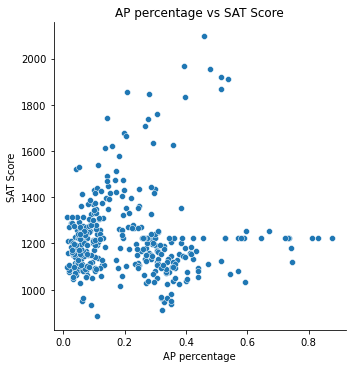

In [51]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
sns.relplot(data=combined, x="ap_per", y="sat_score" )
plt.xlabel('AP percentage')
plt.ylabel('SAT Score')
plt.title('AP percentage vs SAT Score')
plt.show()


The graph of AP percentage and SAT score looks like a C-curve. There are two clusters at the lower left side of the graph. Highest SAT score is recorded with AP percentage between 0.4 and 0.6. As the AP percentage reduces SAT score also reduces as we can see at the left upper side of the graph. At the lower part of the graph SAT score is more or less same against AP percentage.



## 9. Exploring Class Size & SAT Scores
In this section we will find more about how average class size is related to SAT score. Let us look at the correlation value between these two columns.



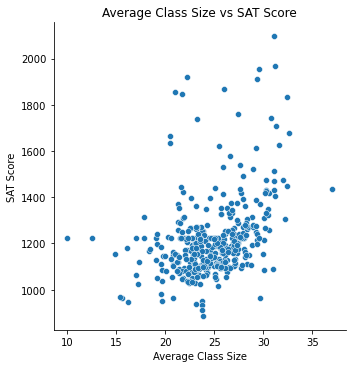

In [57]:
sns.relplot(data=combined, x="AVERAGE CLASS SIZE", y="sat_score")
plt.xlabel("Average Class Size")
plt.ylabel("SAT Score")
plt.title("Average Class Size vs SAT Score")
plt.show()


The scatter plot shoes that there is an exponential increase between SAT scores and avergae class size. There is a cluster between 20 and 30 in the avergae class sixe, and between 1000 and 1300 in the SAT score. 

# Conclusions

In this project, we analyzed SAT Scoes along with dempgraphics of each New Yourk City High School. The main goal of this project was to find out if any demographic factors had a significant impacts on the SAT Scores. From the analysis of the combined datasets, we can make the following observations:

**Analysis of SAT SCORE and Various Surveys**
- We found that with increased student safety score, there eas a graudal increase in SAT Score. Averga esafety values for the five boroughs of NYC show that Manhattean tops the list and Brooklyn is the bottom of the list.

**Analysis of SAT SCORE and Race**
- We found that SAT scores correlate positivey with whites and asians, while blacks and hispanics correlate negatively with SAT Scores. We observed an exponential decrease in SAT Scored with increase in hispanics percentage. 

**Analysis of SAT SCORE and Gender**
- We found that male percentage has a negative correlatino and female percentage has a positive correlation with SAT Scores. 

**Analysis of SAT SCORE and Class Size**
- We found an exponential increase in the Sat score with increase in the class size.



